#Disaster Detection via Twitter

**Final project for General Assembly Data Science course in Austin TX**

Ryan B. Jadrich

LinkedIn: [https://www.linkedin.com/in/ryan-jadrich-71190b5b](https://www.linkedin.com/in/ryan-jadrich-71190b5b)

Email: rjadrich@gmail.com

###1. Project summary
---
**Goal:** Create a predictive model to classify a tweet as pertaining to a disaster event or not, *solely* based on the tweet text.

**Data:** 10,876 classified tweet entries in the "Disasters on Social Media" data set from CrowdFlower at http://www.crowdflower.com/data-for-everyone. Some examples of disasters include structural collapses, wildfires and terrorist attacks. However, this dataset also encompases more "minor" events such as car accidents, etc. These were compiled by searching for tweets with disaster related keywords (i.e., hijacking, hurricane, explosion) and then they were classified as "Relevant", "Not Relevant" or "Can't Decide" with "Relevant" indicating a disaster.

**Auxillary data:** Pretrained "Google News" datset for word2vec at https://code.google.com/archive/p/word2vec/. This will be used to artificially boost the vocabulary of the model which is somewhat limited due to the smaller size of the tweet data set.

**Machine learning tools** 

1. **Natural Language Toolkit (NLTK)** - For initial preprocessing and tokenization of tweets using the nltk.tokenize package.

2. **GENSIM** - For seemless transformation from a high dimensional "bag of words" (BOW) feature space to a lower dimensional "topic" space (each topic expresses discovered relations amongst the words in the Tweet data set using Latent Semantic Indexing or LSI).

3. **Scikit-Learn** - For trivial implementation the final Logistic Regression model which predicts "disaster" or "not disaster" based on each Tweets "topic" representation.

**Using the model**: Clone the entire git repository to your local machine and install any packages not already installed (likely NLTK and GENSIM). All data used by the notebook is included in the repository so, in principle, the notebook should be ready to deploy and improve upon. Please let me know of any major improvements!   :) 

**All of the required imports**

In [1]:
import numpy as np
import pandas as pd
import string
from collections import defaultdict
from nltk.tokenize import TweetTokenizer
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models, similarities
from sklearn import linear_model
from sklearn import cross_validation
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
from scipy import interp
import matplotlib.pyplot as plt
import HTMLParser
import sys
import json
%matplotlib inline 

###2. Check out the data
---

In [23]:
df = pd.read_csv("data/tweets/disaster-tweets.csv")
print df.columns

Index([u'_unit_id', u'_golden', u'_unit_state', u'_trusted_judgments',
       u'_last_judgment_at', u'choose_one', u'choose_one:confidence',
       u'choose_one_gold', u'keyword', u'location', u'text', u'tweetid',
       u'userid'],
      dtype='object')


**Whats relevant?**

1. **_choose_one** - classification ("Relevant", "Not Relevant", or "Can't Decide")

2. **_choose_one_confidence** - the certainty of the final classification

3. **_text** - this is the actual tweet text

**Other, somewhat, relevant details**

1. **_golden** - "TRUE" or "FALSE" to indicate if the assigned classification is at the "golden" level, meaning hundreds of people voted on the classification. If not, five to six people voted on the classification. This is really supposed to be used as a final test set, but I don't do this.

2. **_unit_state** - indicates if the judgement on classifying the tweets is "finalized", "golden" (this is like super finalized) or "not finalized". All tweets are either "finalized" or "golden".

3. **keyword** - while not studied here, understanding what keywords are faithfull indicators of disaster could be useful and improve model performance.

There are 10,876 total tweets with a fairly even representation of both "Relevant" and "Not Relevant" classes. Very few are labeled as "Can't Decide" and they will not be relevant to the binary model developed (discussed below).

**Only keep the columns relevant to this work**

In [24]:
df = df[["choose_one", "text", "choose_one:confidence"]]

**Check for any duplicate tweets and keep only one of the instances**

In [25]:
print "Total tweets: %d" % len(df)
df = df.drop_duplicates(cols = ["text"]).reset_index() #this also resets the index otherwise the numbers will have gaps
print "Total unique tweets: %d" % len(df)

Total tweets: 10876
Total unique tweets: 10678


Indeed, there were a bunch of duplicates! This may be due to re-tweeting CrowdFlower not carefully checking for identical text.

###3. Clean and tokenize all the tweets
---
1. Convert hyphens and apostrophes from utf8 to ascii
2. Remove all remaining utf8 characters
3. Clean any HTML tags using HTMLParser module
4. Break on hyphens
5. Employ NLTK for initial tweet tokenization
  * Keep handles (username) and hashtags and reduce length (e.g., looooooovvvvveeee to looovvveee)
    * In general, the english language has at most three identical letters in a row
6. Introduce special tokens
  * **|-num-|** for numbers (detect comma separation as in 1,000,000)
  * **|-num_alpha-|** for mixed numerical and alphabetical (maybe useful for interstates, planes, trains, ...) 
    * Make sure not to convert handles! These are typically mixed numeric and alphabetic
  * **|-num_units-|** for zero, one, ..., ten
  * **|-num_tens-|** for ten, twenty, ..., ninety
  * **|-num_scales-|** for hundred, thousand, ..., billion
  * **|-website-|** for any hyperlinks
8. Simplify common face emoticons down to just eyes and mouth (nose does not really convey emotion) and normalize (eyes first mouth second)
  * Most common eyes : ; = 8
  * Most common mouths ( ) [ ] d p { } / @ |
9. Stem words using NLTK Porter stemmer (e.g., fires becomes fire)

**NOTE:** stop words (i.e., high frequency words like "and") are not removed as is commonly done in natural language processing tasks. Interestingly, keeping them helps improve the final model performance--perhaps by allowing for better word-word relations to be encoded in the discovered "topics".

*There is much room for improvement! Perhaps using sophisticated regular expressions to better separate conjoined words in hashtags would be useful. Also, a spell checker might be good as tweets are full of mispellings. Perhaps the frequency of mispellings could be tokenized???*

**Assortment of function definitions for cleaning and tokenizing**

In [26]:
#go through and find all utf8 hyphens and apostrophes and convert to ascii
def utf8_to_ascii(tweet):
    utf8_hyphens = "\xe2\x80\x90 \xe2\x80\x91 \xe2\x80\x92 \xe2\x80\x93 \xe2\x80\x94".split()
    utf8_aposts = "\xe2\x80\x98 \xe2\x80\x99 \xe2\x80\x9b \xe2\x80\xb2 \xe2\x80\xb5".split()
    return_tweet = tweet
    for utf8_hyphen in utf8_hyphens:
        return_tweet = return_tweet.replace(utf8_hyphen,"-")
    for utf8_apost in utf8_aposts:
        return_tweet = return_tweet.replace(utf8_apost,"'")
    return return_tweet

#breaks up tags assuming a common format of words with no spacing denoted by capitalization (i.e. CrazyDay or JohnDoe)
def break_tag(tag):
    broken_tag = []
    word = ""
    for letter in tag:
        if letter.isupper():
            if word:
                broken_tag.append(word)
            word = letter[:]
        else:
            word = word + letter
    broken_tag.append(word)
    return broken_tag

#function to break up any tags or handles into words if in a normal format
#clean up hash tags which can contain useful information
def clean_tags(split_tweet):
    split_tweet_return = []
    for entry in split_tweet:
        if (entry[0] == "@" and len(entry) > 1):
            split_tweet_return.append("@")
            split_tweet_return.append(entry[1:])
            #for tag_comp in break_tag(entry[1:]):
                #split_tweet_return.append(tag_comp)
        elif (entry[0] == "#" and len(entry) > 1):
            split_tweet_return.append("#")
            for tag_comp in break_tag(entry[1:]):
                split_tweet_return.append(tag_comp)
        else:
            split_tweet_return.append(entry)
    return split_tweet_return

#go through and label any numeric entries as a special numeric token
def num_token(split_tweet):
    num = "0 1 2 3 4 5 6 7 8 9 ,".split()
    split_tweet_return = []
    for entry in split_tweet:
        if entry == ",":
            split_tweet_return.append(entry)
        else:
            is_other = False
            for char in entry:
                if char not in num:
                    is_other = True
                    break
            if is_other:
                split_tweet_return.append(entry) 
            else:
                split_tweet_return.append("|-num-|")
    return split_tweet_return

#go through and label any mixed number and letter entries as a special numalpha token
#make sure that this does not label anything as num_alpha that came from a handle (which is common)
def num_alpha_token(split_tweet):
    num = "0 1 2 3 4 5 6 7 8 9".split()
    alpha = "a b c d e f g h i j k l m n o p q r s t u v w x y z".split()
    split_tweet_return = []
    prior_entry = ""
    for entry in split_tweet:
        has_num = False
        has_alpha = False
        has_other = False
        for char in entry:
            if char in num:
                has_num = True
            elif char in alpha:
                has_alpha = True
            else:
                has_other = True     
        if (has_num and has_alpha and not has_other and (prior_entry != "@")):
            split_tweet_return.append("|-num_alpha-|")
        else:
            split_tweet_return.append(entry) 
        prior_entry = entry[:]
    return split_tweet_return

#go through and label any numeric words with special tokens
def word_num_token(split_tweet):
    units = [
        "zero", "one", "two", "three", "four", "five", "six", "seven", "eight",
        "nine", "ten", "eleven", "twelve", "thirteen", "fourteen", "fifteen",
        "sixteen", "seventeen", "eighteen", "nineteen"]
    tens = ["twenty", "thirty", "forty", "fifty", "sixty", "seventy", "eighty", "ninety"]
    scales = ["hundred", "thousand", "million", "billion", "trillion"]
    split_tweet_return = []
    for entry in split_tweet:
        if entry in units:
            split_tweet_return.append("|-num_units-|")
        elif entry in tens:
            split_tweet_return.append("|-num_tens-|")
        elif entry in scales:
            split_tweet_return.append("|-num_scales-|")
        else:
            split_tweet_return.append(entry)
    return split_tweet_return

#tokenize a web address if present
def website_tokenize(split_tweet):
    split_tweet_return = []
    for entry in split_tweet:
        if entry[0:4] == "http":
            split_tweet_return.append("|-website-|")
        else:
            split_tweet_return.append(entry)
    return split_tweet_return

#determines if the token is likely an emoji and if so returns a reduced representation
#the reduced representation is to aid in statistics since the eyes and mouth really convey
#emotions with minimal information included from a nose or something else
def is_emoji(token):
    #these features make up most smileys which is ~90% of all emojis
    #faces will be returned all facing the right ala eyes then mouth
    eyes = ": ; = 8"
    mouth = "( ) [ ] d p { } / @ |"
    found_eyes = False
    found_mouth = False
    emoji = ""
    for char in token:
        if (char in eyes and not found_eyes):
            emoji = emoji + char
            found_eyes = True
        if (char in mouth and not found_mouth):
            emoji = emoji + char
            found_mouth = True
    #flip all emojis to face normal direction if needed
    if(found_eyes and found_mouth):
        if emoji[0] in mouth:
            e_mouth = emoji[0]
            e_eyes = emoji[1]
            emoji = ""
            emoji = emoji + e_eyes
            if e_mouth == "(":
                emoji = emoji + ")"
            elif e_mouth == ")":
                emoji = emoji + "("
            elif e_mouth == "[":
                emoji = emoji + "]"
            elif e_mouth == "]":
                emoji = emoji + "["
            #this one is unique as it has a directionality so only need one check
            elif e_mouth == "d":
                emoji = emoji + "p"
            elif e_mouth == "{":
                emoji = emoji + "}"
            elif e_mouth == "}":
                emoji = emoji + "{"
            else:
                emoji = emoji + e_mouth
        return emoji
    else:
        return token   
    
#function to check common happy face tweets and reduce them down to only eyes and a mouth
#these are the dominant features that imply emotion
def downgrade_emoji(split_tweet):
    split_tweet_return = []
    for entry in split_tweet:
        split_tweet_return.append(is_emoji(entry))
    return split_tweet_return

**Function to use the various cleaning functions**

This is just the coded up version of the cleaning and tokenization scheme outlined above.

In [27]:
#function to clean and tokenize the tweets all in one fell swoop
#needed function definitions are defined immediately above
def clean_and_tokenize(df):
    #convert some common utf8 hyphen and apostrophe symbols to ascii 
    df["text"] = df["text"].apply(utf8_to_ascii)
    #go through and convert or remove any remaining utf8 characters
    df["text"] = df["text"].apply(lambda(tweet): tweet.decode("utf8").encode('ascii',  errors='ignore'))
    #clean up any html tags
    html_parser = HTMLParser.HTMLParser()
    df["text"] = df["text"].apply(html_parser.unescape)
    #split text on hypenations
    df["text"] = df["text"].apply(lambda(tweet): tweet.replace("-", " "))
    #start out tokenization using NLTK casual twitter token (store in text_tokenized)
    tknzr = TweetTokenizer(strip_handles=False, reduce_len=True)
    df["text_tokenized"] = df["text"].apply(tknzr.tokenize)
    #split up the tags
    df["text_tokenized"] = df["text_tokenized"].apply(clean_tags)
    #lowercase everything
    df["text_tokenized"] = df["text_tokenized"].apply(lambda(split_tweet): [entry.lower() for entry in split_tweet])
    #tokenize numbers 
    df["text_tokenized"] = df["text_tokenized"].apply(num_token)
    #tokenize mixed alphabetical and numeric entries
    df["text_tokenized"] = df["text_tokenized"].apply(num_alpha_token)
    #tokenize any words that are numbers into base units, tens, and scales
    df["text_tokenized"] = df["text_tokenized"].apply(word_num_token)
    #tokenize website links
    df["text_tokenized"] = df["text_tokenized"].apply(website_tokenize)
    #actually modify the emojis
    df["text_tokenized"] = df["text_tokenized"].apply(downgrade_emoji)
    #go through and stem everything using the Porter Stemmer
    st = PorterStemmer()
    df["text_tokenized_stemmed"] = df["text_tokenized"].apply(lambda(split_tweet): [st.stem(entry) for entry in split_tweet])
    #send back the modified dataframe    
    return df

**Clean and tokenize the tweets**

In [28]:
df = clean_and_tokenize(df)

**Comparison of some raw and tokenized tweets**

In [29]:
tweet_num = 3032 #5000
print "Original:"
print df["text"][tweet_num] + "\n"
print "Tokenized:"
print df["text_tokenized_stemmed"][tweet_num]

Original:
Hear @DrFriedenCDC talk on how to avoid thousands of resistant infections/deaths in next 5 yrs: http://t.co/niV8x5Tbe0 #AdiosSuperBacterias

Tokenized:
[u'hear', u'@', u'drfriedencdc', u'talk', u'on', u'how', u'to', u'avoid', u'thousand', u'of', u'resist', u'infect', u'/', u'death', u'in', u'next', u'|-num-|', u'yr', u':', u'|-website-|', u'#', u'adio', u'super', u'bacteria']


In [30]:
tweet_num = 8
print "Original:"
print df["text"][tweet_num] + "\n"
print "Tokenized:"
print df["text_tokenized_stemmed"][tweet_num]

Original:
#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire   #CAfire #wildfires

Tokenized:
[u'#', u'rocki', u'fire', u'updat', u'=', u'>', u'california', u'hwi', u'.', u'|-num-|', u'close', u'in', u'both', u'direct', u'due', u'to', u'lake', u'counti', u'fire', u'#', u'c', u'afir', u'#', u'wildfir']


###4. Mapping low frequency words onto high frequency analogs
---
**Low frequency words**: occur *once* in the whole cleaned and tokenized tweet data set.

**High frequency words**: occur greater than *once* in the whole cleaned and tokenized tweet data set.

**NOTE**: low frequency words also encompass those with no occurence (as in a new tweet outside of the dataset). Word2vec would be used to map in that case as well.

For this I employ the pre-trained word2vec vectors from the Google News dataset. Word2vec is an unsupervised machine learning tool that creates vector representations of words by analysing a large text corpus (here, Google News). Importantly, the similarity between two words can be quantified by the angle (theta in cartoon below) between the two word vectors.

Mapping a low frequency *stemmed* token via via word2vec amounts to finding the most similar high frequency *stemmed* token by comparing all base *unstemmed* words. This procedure is depicted in the following cartoon where arrows represent a mapping and some actual examples (from mapping procedure carried out below) are shown.

![mapping_visual2](data/images/mapping_procedure.png)

**Load in the pre-trained Google News word vectors**

If cloning this repository, download file "GoogleNews-vectors-negative300.bin.gz" from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing and place in the "data" folder. It is not included due to its large size.

**NOTE**: loading this will eat up a lot of RAM

In [15]:
w2v_model = models.word2vec.Word2Vec.load_word2vec_format('data/trained_google_vectors/GoogleNews-vectors-negative300.bin.gz', binary=True)

**Functions to perform the similarity mapping**

In [31]:
#create the actual mapping dictionary for the low frequency words
def create_low_2_high_map(stem_map_low, stem_map_high):
    #loop over the low stemmed tokens and find a mapping to a high for each
    print "Creating low-to-high frequency token mapping via word2vec:"
    print "Number of low frequency tokens to map: %d" % len(stem_map_low)
    print "Number of high frequency tokens to choose from: %d" % len(stem_map_high)
    iteration = 0
    low_2_high_map = {}
    for low_token_stemmed in stem_map_low:
        sys.stdout.write('\r' + "Mapping token number =  " + ("%d" % iteration))
        low_token = stem_map_low[low_token_stemmed][0] #only one entry for each low token
        #find the most similar high stemmed token
        max_similarity = 0.0
        max_high_token_stemmed = ""
        for high_token_stemmed in stem_map_high:
            for high_token in stem_map_high[high_token_stemmed]:
                try:
                    similarity_1 = w2v_model.similarity(low_token, high_token)
                except:
                    similarity_1 = -1.0    
                try:
                    similarity_2 = w2v_model.similarity(low_token.title(), high_token)
                except:
                    similarity_2 = -1.0      
                try:
                    similarity_3 = w2v_model.similarity(low_token, high_token.title())
                except:
                    similarity_3 = -1.0      
                try:
                    similarity_4 = w2v_model.similarity(low_token.title(), high_token.title())
                except:
                    similarity_4 = -1.0
                
                similarity = max([similarity_1, similarity_2, similarity_3, similarity_4])
                    
                if similarity > max_similarity:
                    max_similarity = similarity
                    max_high_token_stemmed = high_token_stemmed
                    
        if max_high_token_stemmed:
            low_2_high_map[low_token_stemmed] = max_high_token_stemmed
        else:
            low_2_high_map[low_token_stemmed] = "|-no_w2v-|"
        iteration = iteration + 1  
    return low_2_high_map

#removes doubles of a any token entry
def remove_clones(token_list):
    token_list_cleaned = []
    for token in token_list:
        if token not in token_list_cleaned:
            token_list_cleaned.append(token)
    return token_list_cleaned

#initialize the mapping of low frequency words onto high frequency words
def create_token_mappings(df):
    #create a stemmed word to full word map to use with word2vec
    #make sure to only use words for the mapping so check if only alphabetical characters
    print "Creating fundamental token map"
    st = PorterStemmer() 
    texts = df["text_tokenized"]
    stem_map = {}
    for text in texts:
        for token in text:
            if is_word(token):
                token_stemmed = st.stem(token)
                if token_stemmed in stem_map:
                    stem_map[token_stemmed].append(token)
                else:
                    stem_map[token_stemmed] = [token]
                                   
    #create separate high frequency (>1 occurence) and low frequency (=1) stemmmed-unstemmed maps
    print "Separating into high and low frequency maps"
    stem_map_high = {}
    stem_map_low = {}
    for token_stemmed in stem_map:
        token_list = stem_map[token_stemmed] 
        if len(token_list) > 1:
            stem_map_high[token_stemmed] = remove_clones(token_list)
        else:
            stem_map_low[token_stemmed] = token_list
    
    #create a mapping from the low stems to a suitable high stem using word2vec to calculate similarities
    #between the underlying unstemmed words contained in each 
    low_2_high_map = create_low_2_high_map(stem_map_low, stem_map_high)
    
    return (stem_map_high, stem_map_low, low_2_high_map)

#this actually loops through and replaces all of the low frequency stemmed tokens with the high frequency analogs
def map_low_frequency_tokens(split_tweet, low_2_high_map):
    split_tweet_return = []
    for token_stemmed in split_tweet:
        if token_stemmed in low_2_high_map:
            split_tweet_return.append(low_2_high_map[token_stemmed])
        else:
            split_tweet_return.append(token_stemmed)
    return split_tweet_return

#checks of a token is likely a word
def is_word(token):
    alpha = "a b c d e f g h i j k l m n o p q r s t u v w x y z".split()
    for char in token:
        if ((char not in alpha) and (char != "'")):
            return False
    return True

**Create low-to-high stemmed word token mappings**

**NOTE**: if this notebook has been cloned from the Github repository, these mappings will already be included and can be read in in directly instead. In this case, do not execute the following code box.

In [18]:
#make the mapping for low frequecy words and write to a json file for safe keeping
stem_map_high, stem_map_low, low_2_high_map = create_token_mappings(df[["text_tokenized","text_tokenized_stemmed"]])
with open('data/word_2_vec_token_mappings/low_2_high_map.json', 'w') as fp:
    json.dump(low_2_high_map, fp)
with open('data/word_2_vec_token_mappings/stem_map_high.json', 'w') as fp:
    json.dump(stem_map_high, fp)
with open('data/word_2_vec_token_mappings/stem_map_low.json', 'w') as fp:
    json.dump(stem_map_low, fp)

Creating fundamental token map
Separating into high and low frequency maps
Creating low-to-high frequency token mapping via word2vec:
Number of low frequency tokens to map: 8862
Number of high frequency tokens to choose from: 6462
Mapping token number =  8861

**Read in low-to-high stemmed word token mappings from file**

In [32]:
#load in the stored low_2_high_map
stem_map_high = json.load(open('data/word_2_vec_token_mappings/stem_map_high.json'))
stem_map_low = json.load(open('data/word_2_vec_token_mappings/stem_map_low.json'))
low_2_high_map = json.load(open('data/word_2_vec_token_mappings/low_2_high_map.json'))

**Example mapping**

In [33]:
print stem_map_low["judici"]

[u'judicial']


In [34]:
print low_2_high_map["judici"]

administr


In [35]:
print stem_map_high["administr"]

[u'administrative', u'administration', u'administrator']


**Perform the word2vec mapping**

In [36]:
#create a new column of tweets that are now mapped according to word2vec
df["text_tokenized_stemmed_w2v"] = df["text_tokenized_stemmed"].apply(lambda x: map_low_frequency_tokens(x, low_2_high_map))

In [37]:
#amount of tweets where words have been mapped
print "Fraction of tweets mapped: %f" % (float(len(df[df['text_tokenized_stemmed'] != df['text_tokenized_stemmed_w2v']])) / float(len(df)))

Fraction of tweets mapped: 0.484267


###5. Converting tweets into features for modeling
---

**Some useful definitions:**
1. **Bag of words (BOW)**:  this is a vector representation of the form [1,0,0,2,4,0,...,0] where each dimension denotes a particular word and the number specifies how many times that word appears in a particular document (tweet in this case). There is a dimension for every word that appears at least twice (in this case) in the whole "corpus" of tweets (this is our "dictionary"). Since tweets are short the vectors are very sparse (mostfly full of 0's). Please see https://en.wikipedia.org/wiki/Bag-of-words_model for more details.
2. **Term frequency–inverse document frequency (TFIDF)**: rescaled BOW vectors where each word count is penalized (shrunk) in accord with how many of the documents contains the word--effectively adjusting the word counts for how unique each word is. For example, "and" will be heavily penalized, reflecting low information content and common usage. Since this is just a rescaling of each BOW element the new vectors are of the same *high* dimensionality. Please see https://en.wikipedia.org/wiki/Tf%E2%80%93idf for more details.
3. **Latent semantic indexing (LSI)**: through a standard mathematical scheme from linear algebra--singular value decomposition (SVD--the TFIDF vectors are mapped onto a user specified, smaller dimensional space where the new dimensions are linear combinations of the old TFIDF dimensions. These new dimensions (commonly called "topics") are constructed so that the they describe as much variance in the data as possible with rapidly diminishing returns for each new dimension. The outcome is a much more compact vectorial representation of each tweet. Please see for https://en.wikipedia.org/wiki/Latent_semantic_analysis more details.

**Workflow**
1. Create a dictionary and corpus
  * Dictionary: use words from all of the tweets for more tokens
  * Corpus: composed of the tweets with the greatest certainty in their classification. Convert to a BOW representation using the dictionary and then to a TFIDF analog.
2. Create LSI features dataframe of desired dimensionality from the dictionary and TFIDF tweet corpus (the dictionary just relates the new features to the actual words and is not really part of the dimensionality reduction)

**Functions to create the dictionary, corpus and LSI features dataframe**

In [59]:
#makes the gensim dictionary and corpus
def make_dictionary_and_corpus(df_dictionary, df_corpus):
    #the tokenized and stemmed data form our texts database 
    texts = df_dictionary
    
    #check how frequently a given word appears and remove it if only one occurrence
    frequency = defaultdict(int)
    for text in texts:
        for token in text:
            frequency[token] += 1
    texts = [[token for token in text if frequency[token] > 1] for text in texts]
    
    #create a gensim dictionary
    dictionary = corpora.Dictionary(texts)
    
    #create a new texts of only the ones I will analyze
    texts = df_corpus    
    
    #create the bag of words corpus
    corpus = [dictionary.doc2bow(text) for text in texts]
    #corpus = [token_word2vec_map(text, frequency) for text in texts]
    
    #create a tfidf wrapper and convert the corpus to a tfidf format
    tfidf = models.TfidfModel(corpus)
    corpus_tfidf = tfidf[corpus]
    
    #return a tuple with the dictionary and corpus
    return (dictionary, corpus_tfidf, corpus)

#clean the features for use in dataframe
def remove_doc_label(doc):
    cleaned_doc = []
    for element in doc:
        cleaned_doc.append(element[1])
    return cleaned_doc

#takes as input the tweet dataframe, dictionary, corpus and dimensions for the tweets and returns 
#a new dataframe with each tweet characterized by the new lower dimensional features
#also returns the topics if desired
def latent_semantic_analysis(df, dictionary, corpus_tfidf, dimensions, return_topics = False, n_topics = 10, n_words = 10):
    #create a lsi wrapper around the tfidf wrapper
    lsi = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=dimensions, power_iters=5)
    corpus_lsi = lsi[corpus_tfidf]
    
    #create the features for a new dataframe
    features = []
    for doc in corpus_lsi:
        features.append(remove_doc_label(doc))
        
    #create a new dataframe with the features
    df_features = pd.DataFrame(data = features)
    
    #create a merged dataframe from the input (the indicies should match since I reset them earlier on)
    df_merged = pd.concat([df["choose_one"], df_features], axis=1)
    
    #return the new features dataframe devoid of columns that contain nothing
    if return_topics:
        return (df_merged.fillna(0), lsi.print_topics(n_topics, num_words = n_words))
    else:
        return df_merged.fillna(0)

**Create dataframes for constructing the dictionary and corpus**

**Dictionary**: use all the tweets to get maximal word recognition, thus maximizing generalizability to new tweets. Words that tokens that appear only once are excluded.

**Corpus**: only employ tweets of 100% confidence in classification to ensure the reliability of the predictive model. Some of the tweets with less than 100% appeared incorrectly labeled upon personal inspection.

In [44]:
#create separate full and dictionary dataframes
df_full = df[["choose_one","text_tokenized_stemmed","text_tokenized_stemmed_w2v"]]
df_filtered = df[["choose_one","text_tokenized_stemmed","text_tokenized_stemmed_w2v"]][df["choose_one:confidence"] == 1].reset_index()

**Make dictionary and corpus**

In [45]:
#generate the dictionary and the corpus for our tweets
tweet_type = "text_tokenized_stemmed_w2v"
dictionary, corpus_tfidf, corpus_bow = make_dictionary_and_corpus(df_full[tweet_type], df_filtered[tweet_type])

In [46]:
print dictionary

Dictionary(6649 unique tokens: [u'sinjar', u'yellow', u'jihad', u'lord', u'saipan']...)


In [47]:
print "# total tweets: %d" % len(df_full)
print "# high certainty tweets: %d" % len(df_filtered)
print "# lower certainty tweets: %d" % (len(df_full)-len(df_filtered))

# total tweets: 10678
# high certainty tweets: 4953
# lower certainty tweets: 5725


###6. Cross validation of logistic regression model
1. Check the cross validation error for a range of LSI dimensionalities
2. Compare to the training error
3. Decide on an appropriate dimensionality


![mapping_visual2](data/images/logistic_regression.png)

In [60]:
def make_dimensions(max_dimension):
    step_dimension = 1
    current_dimension = 1
    dimensions_return = []
    while current_dimension <= max_dimension:
        dimensions_return.append(current_dimension)
        if current_dimension == 10 * step_dimension:
            step_dimension = step_dimension * 10
        if current_dimension >= 10 and current_dimension < max_dimension:
            dimensions_return.append(current_dimension + step_dimension / 2)
        current_dimension = current_dimension + step_dimension       
    return dimensions_return[:]

In [64]:
def cross_validate_dimensionality(df, dictionary, corpus_tfidf, max_dimensions, cross_val_num):
    #select model
    model = linear_model.LogisticRegression()
    
    #list for returning dimensions
    #dimensions_used = range(1, max_dimensions + 1, 50) []
    dimensions_used = make_dimensions(max_dimensions)
    
    #list for returning the average score from k-fold validation
    average_scores = []
    
    #loop over the dimensions for performing the k-fold validation
    for dimensions in dimensions_used:
        #calculate model dataframe
        df_model = latent_semantic_analysis(df, dictionary, corpus_tfidf, dimensions)
    
        #actual validation
        scores = cross_validation.cross_val_score(model, 
                                                  df_model[[i for i in range(dimensions)]], 
                                                  df_model["choose_one"],
                                                  cv=cross_val_num)
        
        #compute average score
        average_scores.append(np.average(scores))
        
        #print out current dimensionality
        sys.stdout.write('\r' + "Calculating fit for dimensions = " + ("%d" % dimensions))
    
    return (dimensions_used, average_scores)

In [65]:
def absolute_score_dimensionality(df, dictionary, corpus_tfidf, max_dimensions):
    #select model
    model = linear_model.LogisticRegression()
    
    #list for returning dimensions
    #dimensions_used = range(1, max_dimensions + 1)
    dimensions_used = make_dimensions(max_dimensions)
    
    #scores list
    average_scores = []
    
    #loop over the dimensions for performing the k-fold validation
    for dimensions in dimensions_used:
        #calculate model dataframe
        df_model = latent_semantic_analysis(df, dictionary, corpus_tfidf, dimensions)
        
        #create the vectors for fitting
        X = df_model[[i for i in range(dimensions)]]
        y = df_model["choose_one"]

        #fit the model
        model.fit(X, y)

        #compute score
        average_scores.append(model.score(X, y))
        
        #print out current dimensionality
        sys.stdout.write('\r' + "Calculating fit for dimensions = " + ("%d" % dimensions))
    
    return (dimensions_used, average_scores)

**Cross validate with a logistic regression fit across a range of dimensions**

In [66]:
#w2v fitting
dimensions_used_w2v, average_scores_w2v = cross_validate_dimensionality(df_filtered, dictionary, corpus_tfidf, 1000, 8)

Calculating fit for dimensions = 1000

**Fit the whole data set with a logistic regression model across a range of dimensions**

In [67]:
#absolute w2v fitting
abs_dimensions_used_w2v, abs_average_scores_w2v = absolute_score_dimensionality(df_filtered, dictionary, corpus_tfidf, 1000)

Calculating fit for dimensions = 1000

**Plot the cross validation and complete fit scores**

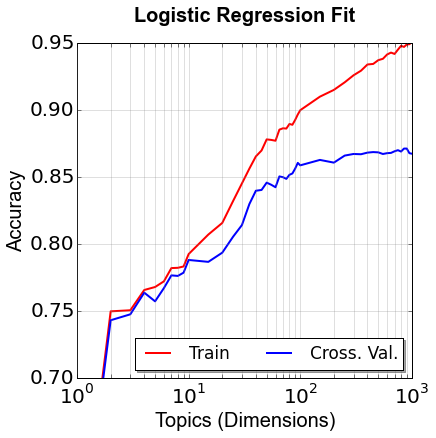

In [78]:
#things to plot
plt.plot(abs_dimensions_used_w2v, abs_average_scores_w2v, c="r", linestyle = '-', linewidth = 2, label = "Train")
plt.plot(dimensions_used_w2v, average_scores_w2v, c="b", linestyle = '-', linewidth = 2, label = "Cross. Val.")

#backround grid details
axes = plt.gca()
axes.grid(b = True, which = 'both', axis = 'both', color = 'gray', linestyle = '-', alpha = 0.5, linewidth = 0.5) 
axes.set_axis_bgcolor('white')  

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}

#figure size and tick style
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

#axis range and labels (also specify if log or not)
plt.xlim(1, 1000)
plt.xscale('log')
plt.ylim(0.70, 0.95)
plt.xlabel(r'Topics (Dimensions)', y=3, fontsize=20, fontdict = axis_label_font)
plt.ylabel(r'Accuracy', fontsize=20, fontdict = axis_label_font)

#title and axis labels
plt.tick_params(axis='both', labelsize=20)
plt.title('Logistic Regression Fit', y=1.05, fontdict = title_font)

#legend details
legend = plt.legend(shadow = True, frameon = True, fancybox = False, ncol = 2, fontsize = 17, loc = 'lower right')
frame = legend.get_frame()
#frame.set_width(100)
frame.set_facecolor('white')
frame.set_edgecolor('black')

plt.show()

**Best cross validation score**

In [82]:
max_score = 0
for entry in zip(average_scores_w2v, dimensions_used_w2v):
    if entry[0] > max_score:
        max_score = entry[0]
        max_d = entry[1]
print (max_score, max_d)

(0.87139565510074291, 850)


**Check out all the scores**

In [81]:
print zip(average_scores_w2v, dimensions_used_w2v)

[(0.54674850060739688, 1), (0.74319745156382577, 2), (0.74762900902637552, 3), (0.76378411052819672, 4), (0.75732305948779644, 5), (0.76721674120202021, 6), (0.77670493086063841, 7), (0.77630072687780771, 8), (0.77872562295921632, 9), (0.78821381156376513, 10), (0.78680057753725874, 15), (0.79366030818290079, 20), (0.80557926298120164, 25), (0.81425546400049509, 30), (0.83000244881396945, 35), (0.83989841680466548, 40), (0.84049902131766774, 45), (0.84595495607397786, 50), (0.84433749188999019, 55), (0.8425206958089021, 60), (0.85059922262805299, 65), (0.84999275643526206, 70), (0.84878145153279405, 75), (0.85180825074067346, 80), (0.85281304869581265, 85), (0.85645185639325128, 90), (0.86069420629503712, 95), (0.858877736975455, 100), (0.86292140428687492, 150), (0.86090038331865226, 200), (0.86614655194512902, 250), (0.8673578610638748, 300), (0.86715624078216336, 350), (0.86836657067046064, 400), (0.86876947076947575, 450), (0.86856362050736657, 500), (0.86735264131233492, 550), (0.

**Conclusion**: Overall, 150 dimensions seems to be a good number as rapidly diminishing returns are found beyond this. The CV accuracy for this dimensionality is ~0.863, not so bad. This is the dimensionality employed for the rest of the notebook.

##Perform ROC analysis
###See how good the model performs by creating a ROC curve (using k-folds)
  * Use 100 features as this as ~ as good as it gets

**Function to perform a k-fold ROC analysis and plot the results**

In [83]:
#color palette
# These are the "Tableau 20" colors as RGB.    
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    
  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)

#so a dimensionality of ~100 seems perfectly fine... lets use this dimensionality and create a k-fold ROC curve
def k_fold_roc(df, dim, cross_val_num):
    #model used
    model = linear_model.LogisticRegression()
    
    #create X and y data but need as a numpy array for easy cv ROC implementation
    #also need to usue dummies for the ROC curve so convert them en route
    X = pd.DataFrame.as_matrix(df[[i for i in range(dim)]])
    y = pd.get_dummies(df["choose_one"])["Relevant"]
    
    #create the cross validation entity to extract the dat from sequentially
    cv = cross_validation.StratifiedKFold(y, n_folds = cross_val_num)
    
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []

    for i, (train, test) in enumerate(cv):
        probas_ = model.fit(X[train], y[train]).predict_proba(X[test])
        
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label='%d (area = %0.2f)' % (i, roc_auc), color = tableau20[i])
        
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

    mean_tpr /= len(cv)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, 'k-',
             label='Mean (area = %0.2f)' % mean_auc, lw=3)
    
    #backround grid details
    axes = plt.gca()
    axes.grid(b = True, which = 'both', axis = 'both', color = 'gray', linestyle = '-', alpha = 0.5, linewidth = 0.5) 
    axes.set_axis_bgcolor('white')  

    #font scpecifications
    title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
    axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}

    #figure size and tick style
    plt.rcParams["figure.figsize"] = [6,6]
    plt.rc('axes',edgecolor='black',linewidth=1)
    plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'
    
    #axis and label details
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate', fontsize=20, fontdict = axis_label_font)
    plt.ylabel('True Positive Rate', fontsize=20, fontdict = axis_label_font)
    
    #title and axis labels
    plt.tick_params(axis='both', labelsize=20)
    plt.title(('%d-fold ROC analysis' % cross_val_num), y=1.05, fontdict = title_font)
    
    #legend details
    legend = plt.legend(shadow = True, frameon = True, fancybox = False, ncol = 1
                        , fontsize = 17, loc = 'lower right', bbox_to_anchor=(1.8, 0.1))
    frame = legend.get_frame()
    frame.set_facecolor('white')
    frame.set_edgecolor('black')
    
    plt.show()

In [84]:
#so a dimensionality of ~150 seems perfectly fine... lets make a final model dataframe of lsi features
dimensions = 150
df_lsi_features, topics = latent_semantic_analysis(df_filtered, dictionary, corpus_tfidf, dimensions, True, 5, 5)

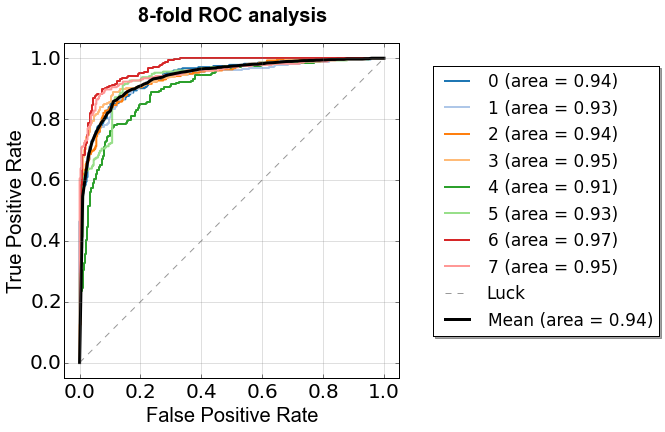

In [86]:
#do a k-fold ROC calculation to check the class separability
k_fold_roc(df_lsi_features, dimensions, 8)

##Check out some pair plots

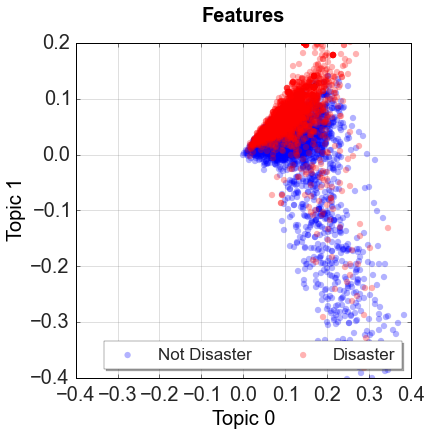

In [79]:
#0 and 5
#separate classified data
feature_1 = 0
feature_2 = 1
feature_1_not_relevant = df_lsi_features[df_lsi_features["choose_one"] == "Not Relevant"][feature_1]
feature_2_not_relevant = df_lsi_features[df_lsi_features["choose_one"] == "Not Relevant"][feature_2]
feature_1_relevant = df_lsi_features[df_lsi_features["choose_one"] == "Relevant"][feature_1]
feature_2_relevant = df_lsi_features[df_lsi_features["choose_one"] == "Relevant"][feature_2]

#things to plot
plt.scatter(feature_1_not_relevant, feature_2_not_relevant, c="b", s=40, alpha=0.3, linewidths=0.0, label = "Not Disaster")
plt.scatter(feature_1_relevant, feature_2_relevant, c="r", s=40, alpha=0.3, linewidths=0.0, label = "Disaster")


#backround grid details
axes = plt.gca()
axes.grid(b = True, which = 'both', axis = 'both', color = 'gray', linestyle = '-', alpha = 0.5, linewidth = 0.5) 
axes.set_axis_bgcolor('white')  

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}

#figure size and tick style
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

#axis range and labels (also specify if log or not)
plt.xlim(-0.4, 0.4)
#plt.xscale('log')
plt.ylim(-0.4, 0.2)
plt.xlabel(r'Topic ' + str(feature_1), y=3, fontsize=20, fontdict = axis_label_font)
plt.ylabel(r'Topic ' + str(feature_2), fontsize=20, fontdict = axis_label_font)

#title and axis labels
plt.tick_params(axis='both', labelsize=20)
plt.title('Features', y=1.05, fontdict = title_font)

#legend details
legend = plt.legend(shadow = True, frameon = True, fancybox = False, ncol = 2, fontsize = 17, loc = 'lower right')
frame = legend.get_frame()
#frame.set_width(100)
frame.set_facecolor('white')
frame.set_edgecolor('black')

plt.show()

In [46]:
feature_1_not_relevant

Series([], Name: 1, dtype: float64)

Number of mislabeled points : 82
Absolutely ridiculously overfit score: 0.917255
[[544  17]
 [ 65 365]]
1.30465116279
1.26578225069


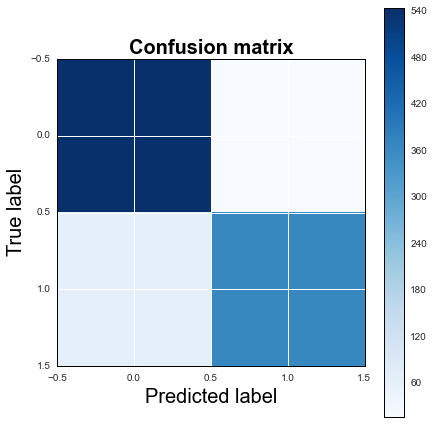

In [243]:
#confusion matrix
X = df_lsi_features[[i for i in range(dimensions)]]
y = df_lsi_features["choose_one"]

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, train_size=0.80)

model = linear_model.LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print "Number of mislabeled points : %d" % (y_test != y_pred).sum()
print "Absolutely ridiculously overfit score: %f" % model.score(X_test, y_test)

cm = metrics.confusion_matrix(y_test, model.predict(X_test))
print cm
plot_confusion_matrix(cm)
print float((cm[0][0]+cm[0][1]))/(cm[1][0]+cm[1][1])
print float(len(df_lsi_features[df_lsi_features["choose_one"]=="Not Relevant"]))/len(df_lsi_features[df_lsi_features["choose_one"]=="Relevant"])

In [219]:

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
    axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}
    plt.rcParams["figure.figsize"] = [6,6]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20, fontdict = title_font)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label', fontsize=20, fontdict = axis_label_font)
    plt.xlabel('Predicted label', fontsize=20, fontdict = axis_label_font)

In [199]:
average_scores2=[]

scores2 = cross_validation.cross_val_score(model, 
                                                  df_lsi_features[[i for i in range(dimensions)]], 
                                                  df_lsi_features["choose_one"],
                                                  cv=8)
        
#compute average score
average_scores2.append(np.average(scores2))
print average_scores2

[0.86897467383298921]


##Train a 110 dimensional model trained on all the data
###Check out the features using 2D and 3D plots

In [54]:
#train the model
model = linear_model.LogisticRegression()

#create the vectors for fitting
X = df_lsi_features[[i for i in range(dimensions)]]
y = df_lsi_features["choose_one"]

#fit the model
model.fit(X, y)

#how did we do
model.score(X, y)

0.90388426476416961

In [70]:
#input a fake tweet and see what the model will predict
#(1) clean the tweet
#(2) w2v the tweet
#(3) create an lsi vector for the tweet
#(4) predict if the tweet is a disaster

user_tweet = "there was a bomb that went off and 12 people were hurt"
user_tweet_list = [user_tweet]
df_user_tweet = pd.DataFrame(data = user_tweet, columns = ["text"])
df_user_tweet = clean_and_tokenize(df_user_tweet)
df_user_tweet = 

SyntaxError: invalid syntax (<ipython-input-70-4adda39ebbdb>, line 11)

In [70]:
df_user_tweet

,text,text_tokenized,text_tokenized_stemmed
0,there was a bomb that went off and 12 people w...,"[there, was, bomb, that, went, off, and, |-num...","[there, wa, bomb, that, went, off, and, |-num-..."


In [ ]:
def replace_w2v(df):
    

In [95]:
lsi.print_topics(5)

NameError: name 'lsi' is not defined

In [58]:
def make_dimensions(max_dimension):
    step_dimension = 1
    current_dimension = 1
    dimensions_return = []
    while current_dimension <= max_dimension:
        dimensions_return.append(current_dimension)
        if current_dimension == 10 * step_dimension:
            step_dimension = step_dimension * 10
        if current_dimension >= 10 and current_dimension < max_dimension:
            dimensions_return.append(current_dimension + step_dimension / 2)
        current_dimension = current_dimension + step_dimension       
    return dimensions_return[:]

In [61]:
make_dimensions(550)
#dimensions_return = [1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100,200,300,400,500,600,700,800,900,1000]

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 15,
 20,
 25,
 30,
 35,
 40,
 45,
 50,
 55,
 60,
 65,
 70,
 75,
 80,
 85,
 90,
 95,
 100,
 150,
 200,
 250,
 300,
 350,
 400,
 450,
 500,
 550]

In [61]:
pd.DataFrame.as_matrix(df_lsi_features[[i for i in range(dimensions)]])[[ 540 , 541 , 542 , 5043, 5044 ,5045]]

array([[  2.79072818e-01,   2.17096090e-01,   3.51310750e-02, ...,
          4.23337529e-02,   5.84360899e-02,   4.59706766e-03],
       [  1.00432609e-01,  -5.44320389e-02,  -6.30802556e-02, ...,
          6.91114866e-02,   6.44028864e-02,  -1.50967619e-02],
       [  5.79314641e-02,  -3.40030187e-02,  -2.98244826e-02, ...,
         -3.08814767e-03,   2.48494049e-02,  -4.06395259e-03],
       [  3.56831077e-02,  -5.16004185e-02,  -5.82089785e-02, ...,
         -5.43151902e-05,   2.89304955e-02,  -1.67400484e-02],
       [  9.54015613e-02,  -9.37836138e-02,  -9.24262904e-02, ...,
          8.18925674e-03,   7.78827135e-03,   1.17490183e-02],
       [  8.92404154e-02,  -1.87124135e-01,  -1.87533680e-01, ...,
         -5.83107574e-03,  -2.48054362e-04,  -5.82864615e-03]])

In [41]:
bob="hello"

In [237]:
dimensions_used = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349]
average_scores = [0.55273536064530759, 0.67409861718848396, 0.66775192337325273, 0.70403631684395185, 0.69749155076716374, 0.73714547925650753, 0.74844715402187201, 0.74646082294655991, 0.74487540800932239, 0.74428237300545486, 0.741504273787298, 0.74249350030556338, 0.73832338877784953, 0.73276688789763278, 0.73573930507369489, 0.74168602807551254, 0.75061585627097882, 0.74883014298507922, 0.74585647304138036, 0.74744472195297218, 0.74546310650300585, 0.75497497724122131, 0.75319020628053912, 0.75259433630250272, 0.75339459137119247, 0.76033432019029101, 0.76152354061368688, 0.76588705276945235, 0.77004680771810452, 0.7710303762858064, 0.77241612075792188, 0.78015233734446943, 0.77916153461855897, 0.79324506290573227, 0.79819878308971259, 0.79700862034109909, 0.79323688542249182, 0.80908916214220583, 0.81425073027454875, 0.81424601464920277, 0.80889547206784074, 0.8194025377173042, 0.82198033958661343, 0.82158917314016588, 0.82475748748122202, 0.81385643040928768, 0.80532278772933186, 0.81385925938456938, 0.81940632301520722, 0.82753653102422564, 0.82139327797480122, 0.82634541795187832, 0.82476063889669748, 0.82595206041183489, 0.82039837950856875, 0.81822277353996387, 0.82118983720899441, 0.81920224536752917, 0.819408514108803, 0.82356732473260863, 0.81841173699102288, 0.82436380850079927, 0.82575049029905934, 0.81622887886754769, 0.80910269113284872, 0.81623203128283772, 0.82158980402314974, 0.82118700323464, 0.82892668467852593, 0.83308642762940333, 0.81979497192860662, 0.82000345375939676, 0.82713341179478039, 0.82714096939299697, 0.819401929830055, 0.83169440232225722, 0.81920256580809392, 0.83149755583334406, 0.82853206237307109, 0.82812643060965052, 0.82218379434982403, 0.83665377045865541, 0.82991969549487954, 0.84360041899428495, 0.82713751253417511, 0.83883568725672764, 0.83323956772497842, 0.84339886187909874, 0.84498490270024718, 0.83447846793376756, 0.84161534668549676, 0.84558926860245953, 0.84915094248318823, 0.84141819575305177, 0.84419849206369202, 0.83804076569877828, 0.83586010966685897, 0.84121757096493743, 0.84102828807312813, 0.84479183950960768, 0.83963090425987796, 0.83051901933229422, 0.84558265932834775, 0.84241119957070365, 0.83705499603933464, 0.84260678829290747, 0.84260929682762442, 0.84161628601127059, 0.84598043204946349, 0.84438556886468685, 0.84319603899868656, 0.8499461744835568, 0.83924099957939802, 0.84360073243614775, 0.84161503524326309, 0.83923627595553574, 0.84578453388465513, 0.84914465264982653, 0.84994019109335595, 0.84815730678273793, 0.84815888598982658, 0.83923942637119664, 0.8396368796515622, 0.8457791873763254, 0.84478743632631026, 0.84359128918768156, 0.8410157064067757, 0.84478712188463279, 0.84974209283662061, 0.84676558691893833, 0.84934935918085919, 0.8447912096264385, 0.84795795075929314, 0.84221152510632336, 0.84598105993300354, 0.84280676320156145, 0.84657252572792796, 0.84320201639000003, 0.84043116832689879, 0.84260898438557619, 0.84082610207458719, 0.8467709374265262, 0.84161250971169865, 0.83527714879444159, 0.84161817466096378, 0.84042769647085858, 0.84597791451641546, 0.84359947866869656, 0.84359758701955956, 0.84835729368916657, 0.83923911592877753, 0.84380072034239095, 0.8465800763274427, 0.84419376943964441, 0.845980115608157, 0.84656559901269512, 0.83705374727095627, 0.84082484130843416, 0.84439375634607283, 0.84141504633720532, 0.84320517180473364, 0.844392182138057, 0.84419534664710383, 0.84278185132221672, 0.8475658469867009, 0.8439937815334011, 0.83983498190755579, 0.84855444762105525, 0.8465731486123953, 0.84776835042636289, 0.83745245031951476, 0.84399787927335246, 0.84261024715135835, 0.84300895619880423, 0.84414566586189588, 0.84221625072981454, 0.8463734771474587, 0.84994427983497622, 0.84717122568106062, 0.83864513060117618, 0.84281180326673011, 0.84439595743781437, 0.84142542791163089, 0.84736680240548978, 0.84598011460834244, 0.84796518891675965, 0.84538141365539521, 0.84915252069046232, 0.84121883772997785, 0.84637662456367591, 0.84657534770450771, 0.85054487443668947, 0.84379631815890788, 0.84459091327740532, 0.84697186565835758, 0.8418181675662797, 0.84577792461054324, 0.84717216500683445, 0.84260866694445513, 0.85113287337464649, 0.84657189084568585, 0.85054298178773802, 0.84974681446085387, 0.8491506270416963, 0.85014710171557373, 0.84795983740935732, 0.84955028441324698, 0.85014237709189699, 0.84776866186859667, 0.84380071434350357, 0.85073919339440929, 0.84895567820080731, 0.8451937009723437, 0.84895315866813026, 0.84816013775764865, 0.8550957788349417, 0.84776645977704057, 0.84994710981007249, 0.83964317048473847, 0.8465744053792903, 0.85014395429935652, 0.84716901559098823, 0.84518646481450621, 0.8477651970112583, 0.8497499638767001, 0.85034173911422906, 0.85034110823124531, 0.84856168477870719, 0.84875411708636284, 0.84677627993559756, 0.84994900345883839, 0.84380166266760837, 0.85232240524027603, 0.84617506944811871, 0.84459122571945355, 0.84479530336713138, 0.8481632841740514, 0.84558455097748475, 0.84697501307457501, 0.85133726546400168, 0.84776771954337904, 0.85093477311828192, 0.85411001317475632, 0.84757182237838524, 0.85074548522740012, 0.84797211263254901, 0.84955154517940001, 0.84439721220508024, 0.84598137037542287, 0.84891040259852601, 0.84836075754669027, 0.84954776788001363, 0.84895095657657416, 0.84895442043409786, 0.84182005521615855, 0.84558360265337984, 0.84459877931841199, 0.8447930982761318, 0.84479561780880874, 0.8445968876692751, 0.84162195895905234, 0.84677187675230003, 0.84434721997763851, 0.84519054855705367, 0.84771897808394503, 0.84578578965173534, 0.84181911289094091, 0.8477702360766125, 0.84875600773568516, 0.84320925454746654, 0.84955123073772276, 0.84930628167087563, 0.84915535166537315, 0.85153158242209237, 0.84975342173533663, 0.84618544902291526, 0.84479467248414775, 0.84142447958752609, 0.85054392411295554, 0.85054644464544715, 0.84757150893652244, 0.85089547190787052, 0.844594685577719, 0.84380449464233376, 0.84737121058786014, 0.84935376436378585, 0.84855728159540966, 0.84657724135327383, 0.84697469763308297, 0.84598169281561653, 0.84181879245037627, 0.84757150693689343, 0.84538644972130572, 0.8457842184431632, 0.85014521206606597, 0.84895882761665376, 0.85331855747395968, 0.84320579668883011, 0.84717248044832649, 0.84975027131967562, 0.8445950040186545, 0.84519212776414232, 0.84558832727705668, 0.84776677421871793, 0.85371538487041421, 0.84360324896938121, 0.84598640744114784, 0.843602938526962, 0.8502794156739808, 0.85014773059892856, 0.8499471148091452, 0.84082798672502235, 0.8505414095793512, 0.84915314757418792, 0.84935502512993888, 0.84717342377335858, 0.84776834642710464, 0.84321020287157133, 0.85133349016424431, 0.85094201127574864, 0.84479058474234203, 0.84875978303544253, 0.84836264419675433, 0.84558675006959705, 0.85094264115891782, 0.84875883971041044, 0.84717436909801958, 0.84796518691713052, 0.84499308418274577, 0.84618135928148042, 0.84479498492619587, 0.84278909147931236, 0.84479373015893011, 0.84380355231711623, 0.84618167672260147, 0.84598042805020524, 0.84756836052049067, 0.84975058976061124, 0.84915660743245347, 0.83884920724903944, 0.84677188075155818, 0.84657913000296703, 0.84419596853175671, 0.8493525065970764, 0.84519118643873936, 0.84499056465006872, 0.8422131013139682, 0.84737561477097223, 0.84855979812864313]

In [12]:
#for dimensions in 
dimensions = 9
latent_semantic_analysis(df_filtered, dictionary, corpus_tfidf, dimensions)[[i for i in range(dimensions)]]

,0,1,2,3,4,5,6,7,8
0,-0.041628,-0.004869,0.002721,-0.003187,-0.033194,0.020223,-0.012484,0.028726,-0.001759
1,-0.024701,0.004142,0.000766,-0.001170,-0.025015,0.013692,-0.004021,0.008281,0.000147
2,-0.027861,0.004450,0.001714,0.000260,-0.023954,0.017186,-0.012836,0.000791,-0.002295
3,-0.067968,0.036593,-0.007588,-0.004199,-0.037605,0.033839,-0.044467,0.040204,0.019735
4,-0.027029,0.013939,-0.001103,0.001685,-0.020928,0.010720,-0.014904,0.012195,0.005891
5,-0.167710,0.238273,-0.067124,0.048576,-0.036743,-0.043723,-0.087961,0.013723,0.035516
6,-0.042530,0.078496,-0.017317,0.018351,-0.002322,-0.006176,-0.026110,-0.005222,-0.010246
7,-0.147889,0.188468,-0.049396,0.027852,-0.050513,-0.003536,-0.091207,0.023457,0.035604
8,-0.065739,0.025710,-0.002412,-0.004272,-0.063975,0.055702,0.088217,0.040236,0.009375
9,-0.120483,-0.024431,-0.002341,0.040224,-0.091603,-0.033091,-0.006536,0.091533,0.069835


In [101]:
df_filtered.tail(40)

,index,choose_one,text_tokenized,text_tokenized_stemmed
5006,10783,Relevant,"[wreckage, ', conclusively, confirmed, ', miss...","[wreckag, ', conclus, confirm, ', miss, flight..."
5007,10784,Relevant,"[wreckage, ', conclusively, confirmed, ', |-nu...","[wreckag, ', conclus, confirm, ', |-num_alpha-..."
5008,10785,Not Relevant,"[wrecked, hour, youtube, @, julian_lage, @, gr...","[wreck, hour, youtub, @, julian_lag, @, grant,..."
5009,10790,Not Relevant,"[cramer, :, igers, |-num-|, words, wrecked, di...","[cramer, :, iger, |-num-|, word, wreck, disney..."
5010,10791,Not Relevant,"[cramer, :, iger's, |-num-|, words, wrecked, d...","[cramer, :, iger', |-num-|, word, wreck, disne..."
5011,10795,Relevant,"[israel, wrecked, home, ., wants, land, ., |-w...","[israel, wreck, home, ., want, land, ., |-webs..."
5012,10797,Not Relevant,"[@, nathan26_, thought, said, saturday, night,...","[@, nathan26_, thought, said, saturday, night,..."
5013,10798,Not Relevant,"[#, news, cramer, :, iger's, |-num-|, words, w...","[#, news, cramer, :, iger', |-num-|, word, wre..."
5014,10800,Not Relevant,"[|-website-|, :, iger's, |-num-|, words, wreck...","[|-website-|, :, iger', |-num-|, word, wreck, ..."
5015,10801,Not Relevant,"[wanna, ease, mind, make, feel, alright, ., ?,...","[wanna, eas, mind, make, feel, alright, ., ?, ..."


In [112]:
df_filtered.tail(40)

,index,choose_one,text_tokenized,text_tokenized_stemmed
5006,10783,Relevant,"[wreckage, ', conclusively, confirmed, ', miss...","[wreckag, ', conclus, confirm, ', miss, flight..."
5007,10784,Relevant,"[wreckage, ', conclusively, confirmed, ', |-nu...","[wreckag, ', conclus, confirm, ', |-num_alpha-..."
5008,10785,Not Relevant,"[wrecked, hour, youtube, @, julian_lage, @, gr...","[wreck, hour, youtub, @, julian_lag, @, grant,..."
5009,10790,Not Relevant,"[cramer, :, igers, |-num-|, words, wrecked, di...","[cramer, :, iger, |-num-|, word, wreck, disney..."
5010,10791,Not Relevant,"[cramer, :, iger's, |-num-|, words, wrecked, d...","[cramer, :, iger', |-num-|, word, wreck, disne..."
5011,10795,Relevant,"[israel, wrecked, home, ., wants, land, ., |-w...","[israel, wreck, home, ., want, land, ., |-webs..."
5012,10797,Not Relevant,"[@, nathan26_, thought, said, saturday, night,...","[@, nathan26_, thought, said, saturday, night,..."
5013,10798,Not Relevant,"[#, news, cramer, :, iger's, |-num-|, words, w...","[#, news, cramer, :, iger', |-num-|, word, wre..."
5014,10800,Not Relevant,"[|-website-|, :, iger's, |-num-|, words, wreck...","[|-website-|, :, iger', |-num-|, word, wreck, ..."
5015,10801,Not Relevant,"[wanna, ease, mind, make, feel, alright, ., ?,...","[wanna, eas, mind, make, feel, alright, ., ?, ..."


In [76]:
df_filtered['text_tokenized_stemmed'][5036]

[u'nw',
 u':',
 u'flash',
 u'flood',
 u'warn',
 u'continu',
 u'shelbi',
 u'counti',
 u'08:00',
 u'pm',
 u'wednesday',
 u'.',
 u'#',
 u'tnwx']

In [45]:
dimensions = 5
[k for k in range(dimensions)]

[0, 1, 2, 3, 4]

In [195]:
model = tree.DecisionTreeClassifier()
#model = RandomForestClassifier(n_estimators = 10) 

for k in range(1,100, 5):

    #model.set_params(criterion = "entropy", max_depth = k, max_features = 6, splitter = "random", min_samples_split = 16)
    model.set_params(min_samples_leaf=6, criterion = "entropy", max_depth = k, splitter = "random", min_samples_split = 2)
    
    #model = RandomForestClassifier(n_estimators = k)
    
    dimensions = 50 

    #calculate model dataframe
    df_model = latent_semantic_analysis(df, dictionary, corpus_tfidf, dimensions)
    
    #actual validation
    scores = cross_validation.cross_val_score(model, 
                                                df_model[[i for i in range(dimensions)]], 
                                                df_model["choose_one"],
                                                cv=8)
        
    print np.average(scores)

0.584737175949
0.577984833373
0.536464539557
0.516056036926
0.499780487715
0.486069219381
0.48109720759
0.482485488592
0.486676410259
0.472762631487
0.462655840095
0.459961314813
0.466809600655
0.486282089398
0.47734186963
0.469803746301
0.478139282726
0.477151319973
0.466216576649
0.472370515717


In [167]:
is_emoji(")-:")

':('

In [12]:
tknzr = TweetTokenizer(strip_handles=False, reduce_len=True)
tknzr.tokenize("#Fire @bob this ia a crzay day. What are you doing")

[u'#Fire',
 u'@bob',
 u'this',
 u'ia',
 u'a',
 u'crzay',
 u'day',
 u'.',
 u'What',
 u'are',
 u'you',
 u'doing']

In [31]:
cross_validation?

In [218]:
def cool_function(var):
    print var
    return var
    

In [219]:
var = 25
print var
print cool_function(30)
print var

25
30
30
25


In [50]:
range(1,6)

[1, 2, 3, 4, 5]

In [ ]:
#takes as input the tweet dataframe, dictionary, corpus and dimensions for the tweets and returns 
#a new dataframe with each tweet characterized by the new lower dimensional features
def latent_dirichlet_analysis(df, dictionary, corpus_bow, dimensions):
    #create a lsi wrapper around the tfidf wrapper
    lda = models.LdaModel(corpus_bow, id2word=dictionary, num_topics=dimensions)
    corpus_lda = lda[corpus_bow]
    
    #create the features for a new dataframe
    features = []
    for doc in corpus_lda:
        features.append(remove_doc_label(doc))
        
    #create a new dataframe with the features
    df_features = pd.DataFrame(data = features)
    
    #create a merged dataframe from the input (the indicies should match since I reset them earlier on)
    df_merged = pd.concat([df["choose_one"], df_features], axis=1)
    
    #return the new features dataframe devoid of columns that contain nothing
    #print lda.print_topics(1)
    
    #return df_merged.dropna()
    return df_merged.fillna(0)

In [3]:
w2v_model = models.word2vec.Word2Vec.load_word2vec_format('C:/Users/rbj428/Documents/general_assembly/DATA/DAT-ATX-1/final_project/social_media_disasters/trained_google_vectors/GoogleNews-vectors-negative300.bin.gz', binary=True)

In [143]:
w2v_model.most_similar('Julio')

[(u'Luis', 0.8596883416175842),
 (u'Jorge', 0.842887282371521),
 (u'Jose', 0.8407859206199646),
 (u'Miguel', 0.8285568952560425),
 (u'Arturo', 0.8134746551513672),
 (u'Roberto', 0.7933327555656433),
 (u'Armando', 0.7908987998962402),
 (u'Jos\xe9', 0.7862284183502197),
 (u'Javier', 0.7765728831291199),
 (u'Mauricio', 0.7693203687667847)]

In [ ]:
#actually uses word2vec to hopefully find a similar word to map infrequent ones onto
#this should help with the generalizability of the model
def w2v_stem_map(token_stemmed_to_map, stem_map):
    st = PorterStemmer()
    token_to_map = stem_map[token_stemmed_to_map][0] #there can only be one unstemmed word and neccesarily in the zeroth position
    max_similarity = 0.0
    max_similar_token = ""
    #loop over the stemmed tokens in the dictionary
    for token_stemmed in stem_map:
        #loop over the various full words that yield the stemmed version
        for token in stem_map[token_stemmed]:
            try:
                similarity = w2v_model.similarity(token_to_map, token)
            except:
                similarity = -1.0
                
            if similarity > max_similarity:
                max_similarity = similarity
                max_similar_token = token
    #should have the token of maximum similarity so now stem and pass back
    if max_similar_token:
        return st.stem(max_similar_token)
    else:
        return "|-no_w2v-|"


#converts the stemmed texts to a version wherby infrequent words are mapped via w2v
def make_texts_w2v(texts_stemmed, frequency, stem_map):
    texts_stemmed_w2v = []
    for text_stemmed in texts_stemmed:
        text_stemmed_w2v = []
        for token_stemmed in text_stemmed:
            if (frequency[token_stemmed] == 1 and token_stemmed.isalpha()):
                token_stemmed_w2v = w2v_stem_map(token_stemmed, stem_map)
                text_stemmed_w2v.append(token_stemmed_w2v)
            else:
                text_stemmed_w2v.append(token_stemmed)
        texts_stemmed_w2v.append(text_stemmed_w2v)
    return texts_stemmed_w2v[:]

#check to see if a token is likely a word (can have apostrophes)
def is_word(token):
    alpha = "a b c d e f g h i j k l m n o p q r s t u v w x y z".split()
    for char in token:
        if ((char not in alpha) or (char != "'")):
            return False
    return True

#makes the gensim dictionary and corpus
def make_dictionary_and_corpus(df_dictionary, df_corpus):
    #create a stemmed word to full word map to use with word2vec
    #make sure to only use words for the mapping so check if only alphabetical characters
    st = PorterStemmer() 
    texts = df_dictionary["text_tokenized"]
    stem_map = {}
    for text in texts:
        for token in text:
            if token.isalpha():
                token_stemmed = st.stem(token)
                if token_stemmed in stem_map:
                    stem_map[token_stemmed].append(token)
                else:
                    stem_map[token_stemmed] = [token]
    
    #now with my stem mapping replace any words that do not apppear more than once
    #the tokenized and stemmed data form our texts database 
    texts_stemmed = df_dictionary["text_tokenized_stemmed"]
    
    #create a frequency dictionary of the stemmed tokens to see if greater than one occurence
    frequency = defaultdict(int)
    for text_stemmed in texts_stemmed:
        for token_stemmed in text_stemmed:
            frequency[token_stemmed] += 1
    
    #create a refined texts document that adds token if >1 occurence
    #if not, attempt to find a similar word according to word2vec
    #and if something not purely alphabetical just drop it
    texts_stemmed_w2v = make_texts_w2v(texts_stemmed[:], frequency, stem_map)
    
    #create a gensim dictionary
    dictionary = corpora.Dictionary(texts_stemmed_w2v)
    
    #create a new texts of only the ones I will analyze
    texts_stemmed = df_corpus["text_tokenized_stemmed"]    
    
    #again convert using w2v mapping
    texts_stemmed_w2v = make_texts_w2v(texts_stemmed[:], frequency, stem_map)    
    
    #create the bag of words corpus
    corpus = [dictionary.doc2bow(text_stemmed_w2v) for text_stemmed_w2v in texts_stemmed_w2v]
    
    #create a tfidf wrapper and convert the corpus to a tfidf format
    tfidf = models.TfidfModel(corpus)
    corpus_tfidf = tfidf[corpus]
    
    #return a tuple with the dictionary and corpus
    return (dictionary, corpus_tfidf, corpus)

In [5]:
dictionary_thing["hello"]

['bob', 'jon']

In [7]:
"jsdjks2k".isalpha()

False

In [10]:
tweet = "hello my nam eis BOZO :) how are you???".split()
add_bigrams(tweet)

['hello',
 'my',
 'nam',
 'eis',
 'BOZO',
 ':)',
 'how',
 'are',
 'you???',
 'hello_my',
 'my_nam',
 'nam_eis',
 'eis_BOZO',
 'BOZO_:)',
 ':)_how',
 'how_are',
 'are_you???']

In [6]:
thing = {1:"one", 2:"two", 3:"three"}

In [4]:
thing2 = thing

In [7]:
thing2

{1: 'one', 2: 'two'}

In [3]:
def is_word(token):
    alpha = "a b c d e f g h i j k l m n o p q r s t u v w x y z".split()
    for char in token:
        if ((char not in alpha) and (char != "'")):
            return False
    return True

In [9]:
is_word("''''''")

True

In [7]:
st = PorterStemmer()
st.stem("felon")

u'felon'

In [1]:
print "hello %d" % 4

hello 4


In [2]:
#function to go through the list of texts to be used for the dictionary
#(1) create a mapping between list of words belonging to stemmed versions
#(2) create a 
gdg = {1:2, 3:4, 5:6}
len(gdg)

3

In [17]:
low_2_high_map = create_token_mappings(df[["text_tokenized","text_tokenized_stemmed"]])

Creating fundamental token map
Separating into high and low frequency maps
Creating low-to-high frequency token mapping via word2vec:
Number of low frequency tokens to map: 8786
Number of high frequency tokens to choose from: 6500
Token number =  8785

{u'kickstart': u'jax',
 u'pardon': u'forgiv',
 u'hitch': u'smooth',
 u'elvi': u'mariah',
 u'nottingham': u'leed',
 u'islamist': u'hama',
 u'liar': u'asshol',
 u'oldest': u'largest',
 u'bfore': u'sunday',
 u'dynasti': u'empir',
 u'auc': u'verano',
 u'pedro': u'carlo',
 u'waar': u'komen',
 u'swam': u'swim',
 u'gemston': u'diamond',
 u'aul': u'aw',
 u'spen': u'er',
 u'emptiv': u'modi',
 u'forebod': u'eeri',
 u'deviat': u'abandon',
 u'sputter': u'stall',
 u'consi': u'freestyl',
 u'hedg': u'deriv',
 u'newli': u'recent',
 u'whack': u'screw',
 u'swivel': u'flip',
 u'avril': u'verano',
 u'wrld': u'hahah',
 u'unknowingli': u'accident',
 u'faction': u'parti',
 u'guardrail': u'overpass',
 u'simmon': u'corey',
 u'dell': u'soni',
 u'disinfo': u'dailyko',
 u'capoeira': u'danc',
 u'loom': u'impend',
 u'crackin': u'gonna',
 u'blubber': u'fat',
 u'emili': u'joel',
 u'vast': u'enorm',
 u'leprosi': u'diseas',
 u'sleet': u'snow',
 u'kettlebel': u'cardio',
 u'prize': u'award',
 u'savvi': u'smart',
 u'unscr

In [18]:
import json
with open('data.json', 'w') as fp:
    json.dump(data, fp)

NameError: name 'data' is not defined

In [19]:
data = {1:2,5:"hello"}
with open('data.json', 'w') as fp:
    json.dump(data, fp)

In [ ]:
#actually uses word2vec to hopefully find a similar word to map infrequent ones onto
#this should help with the generalizability of the model
def w2v_stem_map(token_stemmed_to_map, frequency, stem_map):
    st = PorterStemmer()
    token_to_map = stem_map[token_stemmed_to_map][0] #there can only be one unstemmed word and neccesarily in the zeroth position
    max_similarity = 0.0
    max_similar_token = ""
    #loop over the stemmed tokens in the dictionary
    for token_stemmed in stem_map:
        if ((token_stemmed != token_stemmed_to_map) and (frequency[token_stemmed] > 1)): 
            #loop over the various full words that yield the stemmed version
            for token in stem_map[token_stemmed]:
                try:
                    similarity = w2v_model.similarity(token_to_map, token)
                except:
                    similarity = -1.0
                
                if similarity > max_similarity:
                    max_similarity = similarity
                    max_similar_token = token
    #should have the token of maximum similarity so now stem and pass back
    if max_similar_token:
        print stem_map[token_stemmed_to_map][0]
        print max_similar_token
        print "\n"
        return st.stem(max_similar_token)
    else:
        return "|-no_w2v-|"

#converts the stemmed texts to a version wherby infrequent words are mapped via w2v
def make_texts_w2v(texts_stemmed, frequency, stem_map):
    
    #print out the number of unmatched tokens for w2v to map
    num_to_map = 0
    for entry in frequency:
        if (frequency[entry] == 1 and is_word(entry)):
            num_to_map = num_to_map + 1
    print "Number of word2vec mappings to attemp: %d" % num_to_map
    
    texts_stemmed_w2v = []
    for text_stemmed in texts_stemmed:
        text_stemmed_w2v = []
        for token_stemmed in text_stemmed:
            if (frequency[token_stemmed] == 1 and is_word(token_stemmed)):
                token_stemmed_w2v = w2v_stem_map(token_stemmed, frequency, stem_map)
                text_stemmed_w2v.append(token_stemmed_w2v)
            else:
                text_stemmed_w2v.append(token_stemmed)
        texts_stemmed_w2v.append(text_stemmed_w2v)
    return texts_stemmed_w2v[:]


In [ ]:
#makes the gensim dictionary and corpus
def make_dictionary_and_corpus(df):
    #create a stemmed word to full word map to use with word2vec
    #make sure to only use words for the mapping so check if only alphabetical characters
    st = PorterStemmer() 
    texts = df["text_tokenized"]
    stem_map = {}
    for text in texts:
        for token in text:
            if is_word(token):
                token_stemmed = st.stem(token)
                if token_stemmed in stem_map:
                    stem_map[token_stemmed].append(token)
                else:
                    stem_map[token_stemmed] = [token]
                                   
    #create separate high frequency (>1 occurence) and low frequency (=1) stemmmed-unstemmed maps
    stem_map_high = {}
    stem_map_low = {}
    for token_stemmed in stem_map:
        token_list = stem[token_stemmed] 
        if len(token_list) > 1:
            stem_map_high[token_stemmed] = token_list
        else:
            stem_map_low[token_stemmed] = token_list
    
    #create a mapping from the low stems to a suitable high stem using word2vec to calculate similarities
    #between the underlying unstemmed words contained in each 
    low_2_high_map = create_low_2_high_map(stem_map_low, stem_map_high)    
    
    #then map low to high 
    
    #now with my stem mapping replace any words that do not apppear more than once
    #the tokenized and stemmed data form our texts database 
    texts_stemmed = df["text_tokenized_stemmed"]
    
    #create a frequency dictionary of the stemmed tokens to see if greater than one occurence
    frequency = defaultdict(int)
    for text_stemmed in texts_stemmed:
        for token_stemmed in text_stemmed:
            frequency[token_stemmed] += 1   
    
    #create a refined texts document that adds token if >1 occurence
    #if not, attempt to find a similar word according to word2vec
    #and if something not purely alphabetical just drop it
    print "w2v mapping the dictionary\n"
    texts_stemmed_w2v = make_texts_w2v(texts_stemmed[:], frequency, stem_map)
    
    #create a gensim dictionary
    dictionary = corpora.Dictionary(texts_stemmed_w2v)
    
    #create a new texts of only the ones I will analyze
    #df_corpus = pd.DataFrame[data = texts_stemmed_w2v, index = ""]
    df_corpus = df[df["choose_one:confidence"] == 1].reset_index()
    texts_stemmed = df_corpus["text_tokenized_stemmed"]    
    
    #again convert using w2v mapping
    print "w2v mapping the corpus\n"
    texts_stemmed_w2v = make_texts_w2v(texts_stemmed[:], frequency, stem_map)    
    
    #create the bag of words corpus
    corpus = [dictionary.doc2bow(text_stemmed_w2v) for text_stemmed_w2v in texts_stemmed_w2v]
    
    #create a tfidf wrapper and convert the corpus to a tfidf format
    tfidf = models.TfidfModel(corpus)
    corpus_tfidf = tfidf[corpus]
    
    #return a tuple with the dictionary and corpus
    return (dictionary, corpus_tfidf, corpus)

In [170]:
def cross_validate_dimensionality(df, dictionary, corpus_tfidf, max_dimensions, cross_val_num):
    #select model
    #model = BaggingClassifier(base_estimator=linear_model.LogisticRegression())
    #model = SVC(degree = 3)
    #model = AdaBoostClassifier(base_estimator = linear_model.SGDClassifier(), algorithm='SAMME', n_estimators=200)
    #model = GradientBoostingClassifier(n_estimators =200)
    model = GradientBoostingClassifier(n_estimators =50, loss='exponential')
    
    #list for returning dimensions
    dimensions_used = range(1, max_dimensions + 1, 15)
    
    #list for returning the average score from k-fold validation
    average_scores = []
    
    #loop over the dimensions for performing the k-fold validation
    for dimensions in dimensions_used:
        #calculate model dataframe
        df_model = latent_semantic_analysis(df, dictionary, corpus_tfidf, dimensions)
        #df_model = latent_dirichlet_analysis(df, dictionary, corpus_tfidf, dimensions)
    
        #actual validation
        scores = cross_validation.cross_val_score(model, 
                                                  df_model[[i for i in range(dimensions)]], 
                                                  df_model["choose_one"],
                                                  cv=cross_val_num)
        
        #compute average score
        average_scores.append(np.average(scores))
        
        #print out current dimensionality
        sys.stdout.write('\r' + "dimensions =  " + ("%d" % dimensions))
    
    return (dimensions_used, average_scores)

In [165]:
dimensions_used_ada, average_scores_ada = cross_validate_dimensionality(df_filtered, dictionary, corpus_tfidf, 100, 8)
print "\n"
print dimensions_used_ada
print average_scores_ada

dimensions =  91

[1, 16, 31, 46, 61, 76, 91]
[0.53746167160914982, 0.80025585854335735, 0.83156609112141877, 0.84524242943418859, 0.85237900574201508, 0.84603419257796064, 0.84227410499900479]


In [171]:
dimensions_used_ada, average_scores_ada = cross_validate_dimensionality(df_filtered, dictionary, corpus_tfidf, 100, 8)
print "\n"
print dimensions_used_ada
print average_scores_ada

dimensions =  91

[1, 16, 31, 46, 61, 76, 91]
[0.54181668384148107, 0.79966030400681287, 0.82462698318715844, 0.84306145896059204, 0.83414703740750162, 0.82840029831266904, 0.83612298090950088]


In [203]:
max_score = 0
for entry in zip(average_scores_w2v, dimensions_used_w2v):
    if entry[0] > max_score:
        max_score = entry[0]
        max_d = entry[1]
print (max_d, max_score)

(750, 0.87159628982758974)


In [15]:
stem_map_low

NameError: name 'stem_map_low' is not defined

In [17]:
"jon2" not in ["bob", "tom", "jon"]

True

In [29]:
"barbados".title()

'Barbados'

In [15]:
df

,choose_one,text,choose_one:confidence,text_tokenized,text_tokenized_stemmed
0,Relevant,Just happened a terrible car crash,1.0000,"[just, happened, a, terrible, car, crash]","[just, happen, a, terribl, car, crash]"
1,Relevant,Our Deeds are the Reason of this #earthquake M...,1.0000,"[our, deeds, are, the, reason, of, this, #, ea...","[our, deed, are, the, reason, of, thi, #, eart..."
2,Relevant,"Heard about #earthquake is different cities, s...",1.0000,"[heard, about, #, earthquake, is, different, c...","[heard, about, #, earthquak, is, differ, citi,..."
3,Relevant,"there is a forest fire at spot pond, geese are...",0.9603,"[there, is, a, forest, fire, at, spot, pond, ,...","[there, is, a, forest, fire, at, spot, pond, ,..."
4,Relevant,Forest fire near La Ronge Sask. Canada,1.0000,"[forest, fire, near, la, ronge, sask, ., canada]","[forest, fire, near, la, rong, sask, ., canada]"
5,Relevant,All residents asked to 'shelter in place' are ...,1.0000,"[all, residents, asked, to, ', shelter, in, pl...","[all, resid, ask, to, ', shelter, in, place, '..."
6,Relevant,"13,000 people receive #wildfires evacuation or...",1.0000,"[|-num-|, people, receive, #, wildfires, evacu...","[|-num-|, peopl, receiv, #, wildfir, evacu, or..."
7,Relevant,Just got sent this photo from Ruby #Alaska as ...,1.0000,"[just, got, sent, this, photo, from, ruby, #, ...","[just, got, sent, thi, photo, from, rubi, #, a..."
8,Relevant,#RockyFire Update => California Hwy. 20 closed...,1.0000,"[#, rocky, fire, update, =, >, california, hwy...","[#, rocki, fire, updat, =, >, california, hwi,..."
9,Relevant,Apocalypse lighting. #Spokane #wildfires,0.9606,"[apocalypse, lighting, ., #, spokane, #, wildf...","[apocalyps, light, ., #, spokan, #, wildfir]"


In [28]:
linear_model.LogisticRegression?

In [23]:
hello = "hi"
hello2 = hello
hello2 = "bob"
print hello
print hello2

hi
bob


In [54]:
dimensions = 300
df_lsi_features = latent_semantic_analysis(df_filtered, dictionary, corpus_tfidf, dimensions)
df_lsi_features[:4]

,choose_one,0,1,2,3,4,5,6,7,8,...,290,291,292,293,294,295,296,297,298,299
0,Relevant,0.061330,0.019488,-0.046060,0.012138,0.000535,-0.015414,-0.005995,0.006422,-0.006186,...,0.032637,-0.021544,0.007953,-0.001603,0.010942,-0.038680,-0.016199,-0.020319,-0.015443,0.018396
1,Relevant,0.092760,0.040642,-0.021542,0.004852,0.016495,-0.000294,0.041719,0.009049,0.028880,...,-0.046571,-0.015113,-0.009798,-0.016323,-0.005727,-0.012309,0.011591,0.040875,0.012714,-0.030470
2,Relevant,0.071790,0.029462,-0.019487,-0.027494,0.037075,0.006405,0.046488,-0.001963,0.014301,...,-0.002980,-0.067522,-0.036622,-0.010972,0.086000,-0.075995,-0.009428,-0.009989,0.013065,-0.044222
3,Relevant,0.044593,0.023855,-0.008577,-0.008896,0.025584,0.014839,0.001391,0.005645,0.008299,...,-0.021764,0.054427,-0.010458,0.002016,-0.007316,0.017262,0.029926,-0.030480,0.004639,-0.012903


In [51]:
return_topics = False, n_topics = 10, n_words = 10

(0,
 u'0.426*"?" + 0.234*"#" + 0.205*"@" + 0.196*"|-no_w2v-|" + 0.188*"\'" + 0.185*"." + 0.183*"the" + 0.160*"|-num-|" + 0.158*"i" + 0.156*"a"')

In [57]:
dimensions = 300
df_lsi_features, topics = latent_semantic_analysis(df_filtered, dictionary, corpus_tfidf, dimensions, True, 5, 6)
topics

[(0,
  u'0.426*"?" + 0.234*"#" + 0.205*"@" + 0.196*"|-no_w2v-|" + 0.188*"\'" + 0.185*"."'),
 (1,
  u'-0.808*"?" + 0.160*"|-num-|" + 0.159*"\'" + 0.148*":" + 0.127*"#" + 0.110*"of"'),
 (2,
  u'0.296*"?" + 0.235*"\'" + -0.216*"@" + 0.198*"famili" + -0.181*"a" + 0.177*":"'),
 (3,
  u'0.284*"sandstorm" + 0.283*"airport" + 0.282*"swallow" + 0.271*"by" + 0.269*"minut" + 0.263*"under"'),
 (4,
  u'0.477*"\'" + -0.424*"#" + 0.246*"famili" + 0.197*"legionnair" + -0.156*"|-num-|" + -0.122*"california"')]